# Pretrained CNN - Feature Extraction with Data Augmentation
<br>In diesem Code Notebook behandeln wir Feature Extraction mit Data Augmentation, dies sollte nur auf Server mit GPU laufen.

### Load Packages

In [1]:
from keras.callbacks import CSVLogger
import pandas as pd
import os
import tensorflow as tf
from tensorflow import keras

import matplotlib
import matplotlib.pyplot as plt # plotting library
%matplotlib inline
matplotlib.get_backend()

2023-04-20 08:34:42.768010: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-04-20 08:34:42.770151: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-04-20 08:34:42.811612: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-04-20 08:34:42.812881: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-04-20 08:34:43.497740: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Co

'module://matplotlib_inline.backend_inline'

### Load Path Files

In [2]:
original_dataset_dir = '../data/train'

base_dir = '../data/cats_and_dogs_2k/'

train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'validation')
test_dir = os.path.join(base_dir, 'test')

train_cats_dir = os.path.join(train_dir, 'cats')
train_dogs_dir = os.path.join(train_dir, 'dogs')

validation_cats_dir = os.path.join(validation_dir, 'cats')
validation_dogs_dir = os.path.join(validation_dir, 'dogs')

test_cats_dir = os.path.join(test_dir, 'cats')
test_dogs_dir = os.path.join(test_dir, 'dogs')

### Data Preparation with Data Augmentation

In [3]:
train_datagen = keras.preprocessing.image.ImageDataGenerator(
                                                                rescale=1./255,
                                                                rotation_range=40,
                                                                width_shift_range=0.2,
                                                                height_shift_range=0.2,
                                                                shear_range=0.2,
                                                                zoom_range=0.2,
                                                                horizontal_flip=True
                                                             )

test_datagen = keras.preprocessing.image.ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size = (150, 150),
    batch_size = 20,
    class_mode = 'binary'
)

validation_generator = test_datagen.flow_from_directory(
    validation_dir,
    target_size = (150,150),
    batch_size = 20,
    class_mode = 'binary'
)

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


### Load Convolutional Base

In [4]:
conv_base = tf.keras.applications.VGG16(weights='imagenet',
                                        include_top=False,
                                        input_shape=(150,150,3))
print(conv_base.summary())



### Model building
model = tf.keras.models.Sequential()
model.add(conv_base)
model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dense(256, activation='relu'))
model.add(tf.keras.layers.Dropout(0.5))
model.add(tf.keras.layers.Dense(1, activation='sigmoid'))

2023-04-20 08:34:44.985755: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1956] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 150, 150, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 150, 150, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 150, 150, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 75, 75, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 75, 75, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 75, 75, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 37, 37, 128)       0     

### Compiling

In [5]:
model.compile(loss='binary_crossentropy',
              metrics=['acc'],
              optimizer=tf.keras.optimizers.RMSprop(learning_rate=2e-5))

In [6]:
# Freezing the convolutional base layer
conv_base.trainable = False

### Fit Model

In [7]:
LogFile = 'cats_and_dogs_pretrained_with_data_augmentation.log'
csv_logger = CSVLogger(LogFile, separator=',', append=False)
history = model.fit_generator(
    train_generator,
    steps_per_epoch=100,
    epochs=30,
    validation_data= validation_generator,
    validation_steps=50,
    callbacks=[csv_logger]
)

Epoch 1/30


/tmp/ipykernel_1794409/4055857713.py:3: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(
2023-04-20 08:34:45.779631: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


100/100 [==============================] - ETA: 0s - loss: 0.6112 - acc: 0.6590

2023-04-20 08:35:46.460157: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


100/100 [==============================] - 74s 727ms/step - loss: 0.6112 - acc: 0.6590 - val_loss: 0.2533 - val_acc: 0.8920
Epoch 2/30
100/100 [==============================] - 75s 746ms/step - loss: 0.3666 - acc: 0.8315 - val_loss: 0.1746 - val_acc: 0.9220
Epoch 3/30
100/100 [==============================] - 74s 741ms/step - loss: 0.2991 - acc: 0.8695 - val_loss: 0.1609 - val_acc: 0.9390
Epoch 4/30
100/100 [==============================] - 74s 742ms/step - loss: 0.2332 - acc: 0.9035 - val_loss: 0.1316 - val_acc: 0.9470
Epoch 5/30
100/100 [==============================] - 74s 743ms/step - loss: 0.1961 - acc: 0.9170 - val_loss: 0.1068 - val_acc: 0.9590
Epoch 6/30
100/100 [==============================] - 74s 741ms/step - loss: 0.1651 - acc: 0.9330 - val_loss: 0.0906 - val_acc: 0.9680
Epoch 7/30
100/100 [==============================] - 74s 740ms/step - loss: 0.1578 - acc: 0.9345 - val_loss: 0.0922 - val_acc: 0.9620
Epoch 8/30
100/100 [==============================] - 72s 722ms/st

### Save model

In [8]:
model.save('cats_and_dogs_pretrained_with_data_augmentation.h5')
#log_data = pd.read_csv(LogFile, sep=',', engine='python')

In [9]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc)+1)

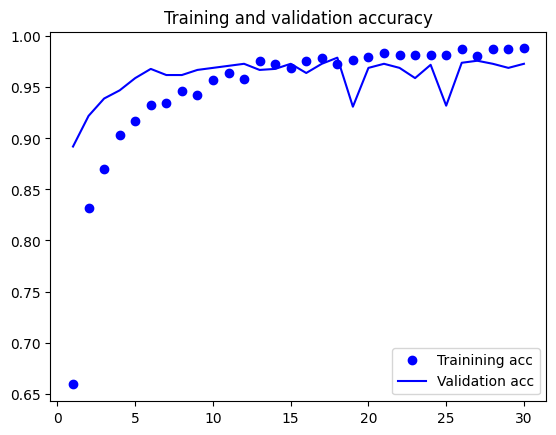

In [10]:
plt.plot(epochs, acc, 'bo', label = 'Trainining acc')
plt.plot(epochs, val_acc, 'b', label = 'Validation acc')
plt.title('Training and validation accuracy')
plt.legend()
plt.show()

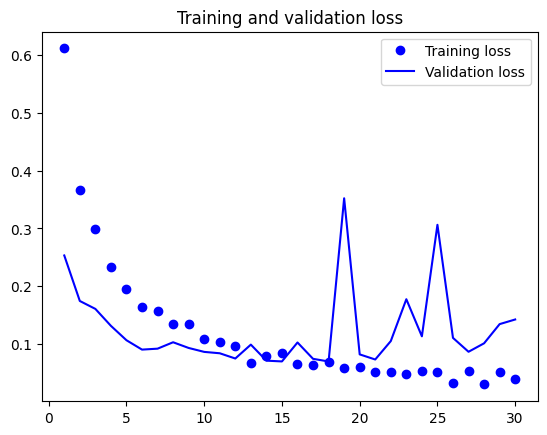

In [11]:
plt.plot(epochs, loss, 'bo', label = 'Training loss')
plt.plot(epochs, val_loss, 'b', label = 'Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()